In [1]:
import sklearn
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [2]:
import torch

In [3]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import os
import glob
import tqdm
from torch.utils.tensorboard import SummaryWriter


In [9]:
def detect_pattern(pattern, image, min_matches=10, trees=3, checks=50):
    MIN_MATCH_COUNT = min_matches
    # Initiate SIFT detector
    sift = cv.xfeatures2d.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(pattern,None)
    kp2, des2 = sift.detectAndCompute(image,None)
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = trees)
    search_params = dict(checks = checks)
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        try:
            M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
            matchesMask = mask.ravel().tolist()
            h,w,d = image.shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
            dst = cv.perspectiveTransform(pts,M)
            return dst, len(good)
        except:
            print("Error!")
            return [], len(good)
    else:
#         print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None
        return [], len(good)

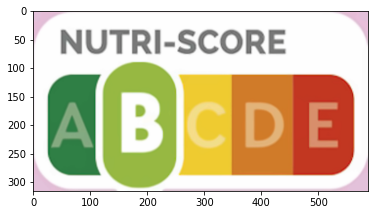

In [10]:
pattern = cv.imread('data/nutri-score.png')   
# pattern = pattern[80:, :, :]
pattern = cv.fastNlMeansDenoisingColored(pattern,None,5,3,7,21)# queryImage
# pattern = cv.cvtColor(pattern, cv.COLOR_BGR2GRAY)
# plt.imshow(pattern)
plt.imshow(cv.cvtColor(pattern, cv.COLOR_BGR2RGB))


In [11]:
def enlarge_box(bbox, image):
    h, w, _ = image.shape
    min_x, min_y = np.min(bbox, axis=0)[0]
    min_x, min_y = max(0, min_x-50), max(0, min_y-50)
    max_x, max_y = np.max(bbox, axis=0)[0]
    max_x, max_y = min(w, max_x + 50), min(h, max_y + 50)
    return int(max_x), int(max_y), int(min_x), int(min_y)


In [12]:
def prepare_label_dataset(label, pattern):
    images = glob.glob(f"data/images/{label}/*.jpg")
    data = []
    for image in tqdm.tqdm(images, ascii=False):
        img2 = cv.imread(image) # trainImage 
        img2 = cv.fastNlMeansDenoisingColored(img2,None,5,2,3,21)
#         img2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
        bbox, matches = detect_pattern(pattern, img2, min_matches=10, trees=3, checks=10)
        if(len(bbox) > 0):
            max_x, max_y, min_x, min_y = enlarge_box(bbox, img2)
            data.append({
                "image": img2[min_y:max_y,min_x:max_x],
                "x1": (min_x, min_y),
                "x2": (max_x, max_y),
                "label": label,
                "matches": matches,
                "area": (max_x - min_x) * (max_y - min_y)
            })
            
    return data


In [13]:
A = prepare_label_dataset("A", pattern)

100%|██████████| 243/243 [07:50<00:00,  1.94s/it]


In [14]:
B = prepare_label_dataset("B", pattern)

100%|██████████| 138/138 [04:22<00:00,  1.90s/it]


In [15]:
C = prepare_label_dataset("C", pattern)

100%|██████████| 96/96 [02:37<00:00,  1.64s/it]


In [16]:
D = prepare_label_dataset("D", pattern)

100%|██████████| 131/131 [03:39<00:00,  1.67s/it]


In [17]:
E = prepare_label_dataset("E", pattern)

100%|██████████| 47/47 [01:17<00:00,  1.64s/it]


In [19]:
def save_preprocessed_data(label, data): 
    for idx, item in tqdm.tqdm(enumerate(data), ascii=False):
        image = item['image']
        cv.imwrite(f"data_clean/{label}/{idx}.jpg", image)

In [20]:
save_preprocessed_data("A", A)
save_preprocessed_data("B", B)
save_preprocessed_data("C", C)
save_preprocessed_data("D", D)
save_preprocessed_data("E", E)

214it [00:02, 83.21it/s]
133it [00:01, 131.58it/s]
83it [00:00, 138.63it/s]
119it [00:00, 147.03it/s]
40it [00:00, 161.19it/s]
